[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [4. 4. 4. ... 4. 4. 4.]
 ...
 [0. 1. 1. ... 1. 1. 0.]
 [0. 0. 1. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


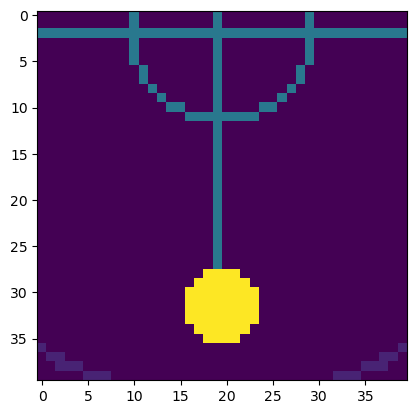

In [10]:
import torch
import torch.nn.functional as F
import torch.optim as optim

import numpy
import time
import os
CURRENT_PATH = os.getcwd()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

from olympics_engine.scenario import wrestling
from olympics_engine.generator import create_scenario
gamemap =  create_scenario('wrestling')        #load map config
game = wrestling(gamemap)
obs = game.reset()

import matplotlib.pyplot as plt
plt.imshow(obs[0]['agent_obs'])

import random
import pygame


print(obs[1]['agent_obs'])

In [11]:
# 加载专家策略
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.Conv = torch.nn.Conv2d(in_channels=1, out_channels=1 ,kernel_size=3, padding=1)
        self.BN = torch.nn.BatchNorm2d(num_features=1)
        self.Pool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.NN1 = torch.nn.Linear(1600, 400)
        self.NN2 = torch.nn.Linear(400, 128)
        self.NN3 = torch.nn.Linear(128, 64)
        self.NN4 = torch.nn.Linear(64, 2)


    def forward(self, input):
        x = self.Conv(input)
        x = self.BN(x)
        x = F.relu(x)
        x = self.Pool(x)
        x = F.dropout(x, p=0.2)
        x = torch.flatten(input, start_dim=1)

        x = self.NN1(x)
        x = F.relu(x)
        x = self.NN2(x)
        x = F.relu(x)
        x = self.NN3(x)
        x = F.relu(x)
        x = self.NN4(x)

        x[:, 0] = torch.tanh(x[:, 0])*150 + 50
        x[:, 1] = torch.tanh(x[:, 1])*30

        return x

expert = CNN().to(device)
expert.load_state_dict(torch.load('./expert.pt'))
expert.eval()


CNN(
  (Conv): Conv2d(1, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (BN): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (Pool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (NN1): Linear(in_features=1600, out_features=400, bias=True)
  (NN2): Linear(in_features=400, out_features=128, bias=True)
  (NN3): Linear(in_features=128, out_features=64, bias=True)
  (NN4): Linear(in_features=64, out_features=2, bias=True)
)

In [3]:
# 设置训练网络
class agent(torch.nn.Module):
    def __init__(self):
        super(agent, self).__init__()
        self.Conv = torch.nn.Conv2d(in_channels=1, out_channels=1 ,kernel_size=3, padding=1)
        self.BN = torch.nn.BatchNorm2d(num_features=1)
        self.Pool = torch.nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        self.NN1 = torch.nn.Linear(1600, 800)
        self.NN2 = torch.nn.Linear(800, 128)
        self.NN3 = torch.nn.Linear(128, 64)
        self.NN4 = torch.nn.Linear(64, 2)


    def forward(self, input):
        x = self.Conv(input)
        x = self.BN(x)
        x = F.relu(x)
        x = self.Pool(x)
        x = F.dropout(x, p=0.2)
        x = torch.flatten(input, start_dim=1)

        x = self.NN1(x)
        x = F.relu(x)
        x = self.NN2(x)
        x = F.relu(x)
        x = self.NN3(x)
        x = F.relu(x)
        x = self.NN4(x)

        x[:, 0] = torch.tanh(x[:, 0])*150 + 50
        x[:, 1] = torch.tanh(x[:, 1])*30

        return x

model = agent().to(device)
optimizerA = optim.Adam(agent.parameters(), 0.01)


In [12]:
def compute_returns(next_value, rewards, masks, gamma=0.99):
    R = next_value
    returns = []
    for step in reversed(range(len(rewards))):
        R = rewards[step] + gamma * R * masks[step]
        returns.insert(0, R)
    return returns

In [9]:
for i in range(50):

    # 需要记录的状态

    our_team = 0        #we control team_0
    obs = game.reset()

    done = False
    RENDER = False

    if RENDER:
        game.render()

    while not done:
        #学习的策略
        #action_team_0 = [random.uniform(-100,200), random.uniform(-30, 30)]     #for now we use random actions for both teams
        #action_team_0 = [26, 0]
        agent_obs = torch.tensor([[obs[0]['agent_obs']]], dtype=torch.float32)
        agent_obs = agent_obs.to(device)
        agent_action = model(agent_obs)[0].cpu()
        action_team_0 = [agent_action[0].item(), agent_action[1].item()]


        #专家策略给的行动
        expert_obs = torch.tensor([[obs[1]['agent_obs']]], dtype=torch.float32)
        expert_obs = expert_obs.to(device)
        expert_action = expert(expert_obs)[0].cpu()
        action_team_expert = [expert_action[0].item(), expert_action[1].item()]

        input_action = [action_team_0, action_team_expert]

        next_obs, reward, done, _ = game.step(input_action)
        if RENDER:
            time.sleep(0.05)
            game.render()
        
        obs = next_obs
    print('final reward = ', reward)
    pygame.display.quit()
    #pygame.quit()

final reward =  [0.0, 1]
